# NEURON Tutorial: Defining your own synapses

## Introduction

This tutorial will give you an introduction to the NMODL language,
which allows you to define your own synapse models for the NEURON simulator.
We will walk you through this process, and the NMODL syntax, on the example of 
a model of AMPA and NMDA glutamate receptors.

You will learn how to:
* Make your own NMODL .mod file
* Model AMPA and NMDA glutamate receptors using the NMODL language
* Compile your .mod file
* Insert it into a simple neuron and stimulate it.

## MOD Files: Editing and Syntax

The NMODL language is a domain specific language of the NEURON simulator to define extensions, such as ion channel or synapse models.  To use NMODL, the user writes .mod files adhering to the NMODL language syntax.  These are programs external to python, and so must be editing using an external editor.

Here, we will use the embedded editing capabilities of Jupyter.

## Compiling MOD files

MOD files need to be compiled before they can be used with NEURON.  
NEURON provides a tool called "nrnivmodl", which has the syntax:
```bash
$ nrnivmodl <directory>
```
Invocation will compile all `.mod` files found in `<directory>`, if specified, otherwise the current directory.

Our `.mod` file is located in "`mechanisms`", so we compile it as follows (the prefix `!` is used to invoke a system call outside python):

In [2]:
!nrnivmodl  mechanisms


/home/ebmuller/ownCloud/meetings/MOOC/SynTutorials/jupyter_home
mechanisms/DetAMPANMDA.mod mechanisms/DetAMPANMDA_int.mod mechanisms/SimpleAMPA_NMDA.mod mechanisms/vecevent.mod
DetAMPANMDA.mod DetAMPANMDA_int.mod SimpleAMPA_NMDA.mod vecevent.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  DetAMPANMDA.lo DetAMPANMDA_int.lo SimpleAMPA_NMDA.lo vecevent.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -L"/usr/local/nrn/x86_64/lib" "/usr/local/nrn/x86_64/lib/libnrniv.la" -livoc -lneuron_gnu -lmescha

## nrnivmodl: Verify successful compilation

The output above indicates `nrnivmodl` completed successfully.  If error messages are generated, then something maybe wrong in your `.mod` file program.  Double-check your .mod file, and try again. 

## Trying out your new synapse model

If your .mod files are compiled before you import neuron, NEURON will load your compiled models automatically if they are in your local directory.

In [3]:
import neuron
from neuron import h
import numpy
import matplotlib.pyplot as plt
# Load external files & initialize
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

If you forgot to compile your .mod files before importing neuron, you can trigger NEURON to load them as follows.  Note, this command can only be executed once for a given directory of .mod files.  Executing it a second time will crash your jupyter kernel.  

In [4]:
#neuron.load_mechanisms(".")

## A neuron to host your synapse

Following previous exercises, we will create a single compartment soma neuron to host the synapse.

In [5]:
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

In [6]:
# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

Create the synapse at the center of the soma compartment

In [7]:
synapse = h.SimpleAMPA_NMDA(soma(0.5))

Define the stimulus: 8 spikes at 20Hz + 1 spike 500 ms later

In [8]:
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

Create a recorder for the synaptic conductance, current, the soma voltage, and the time intervals

In [9]:
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)

1.0

First, let's zero the NMDA conductance, and validate that the AMPA conductance is behaving as we expect
First we simulate, then we plot the voltage, and the conductance trajectories.

In [10]:
h.tstop = 1000.0 # ms
synapse.gmax_NMDA = 0.0
synapse.gmax_AMPA = 0.001 # uS
neuron.h.run()

0.0

<IPython.core.display.Javascript object>


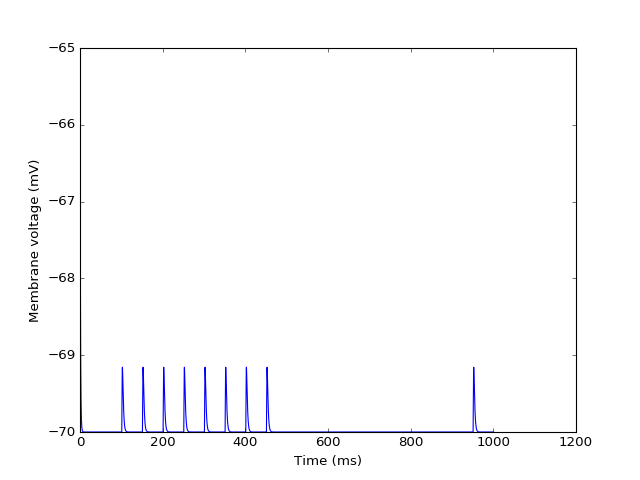

In [11]:
# This command gives us fancy interactive inline plots
%matplotlib notebook

def plot_timecourse(time_array, dependent_var, newfigure=True, show=True, label=None, ylabel='Membrane voltage (mV)', constants=[]):
    """Convenience function to plot time courses of dependent variables"""
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    if show:
        plt.show()
        
plot_timecourse(time, v_soma)

The dual exponential model for the conductance time course has a closed form for the response due to a single pulse.
Below we validate our .mod file implementation running in NEURON against this closed form solution. 

<IPython.core.display.Javascript object>


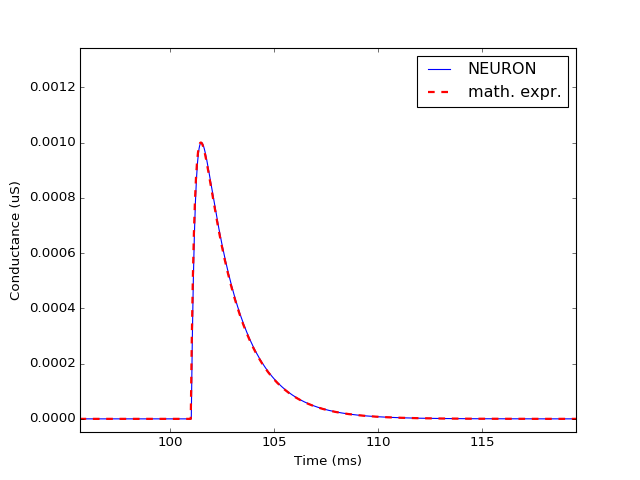

In [12]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON")

def dual_exp(t, tau_r, tau_d, t_start):
    """Compute the dual exponential time course using the closed form expression."""
    t = numpy.array(t)
    time_to_peak = (tau_r*tau_d)/(tau_d-tau_r)*numpy.log(tau_d/tau_r)
    factor = -numpy.exp(-time_to_peak/tau_r)+numpy.exp(-time_to_peak/tau_d)
    f_dual_exp = lambda t: (numpy.exp(-t/tau_d) - numpy.exp(-t/tau_r))/factor
    dual_exp = numpy.zeros_like(t)
    dual_exp[t>=t_start] = f_dual_exp(t[t>=t_start]-t_start)
    return dual_exp
    
plt.plot(time, 0.001*connection.weight[0]*dual_exp(time, synapse.tau_r_AMPA, synapse.tau_d_AMPA, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

Now, let's also validate the trajectory for the NMDA receptor alone
Here, we have to remove the Magnesium block by zeroing the Mg2+ concentration

In [13]:
synapse.gmax_NMDA = 0.001 # uS
synapse.mg = 0.0 # mM
synapse.gmax_AMPA = 0 # uS
neuron.h.run()

0.0

<IPython.core.display.Javascript object>


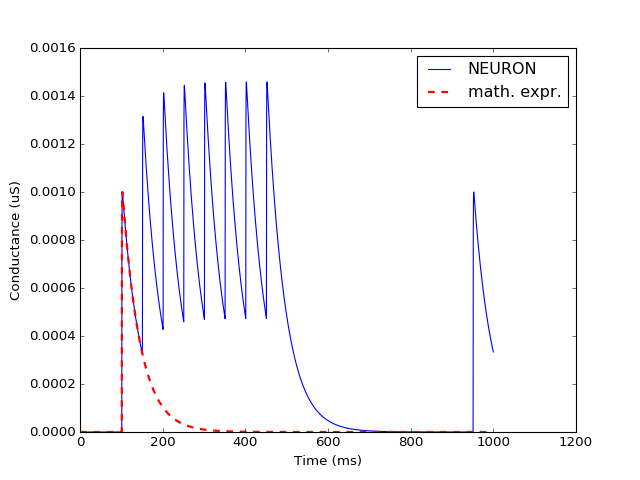

In [14]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON")
plt.plot(time, 0.001*connection.weight[0]*dual_exp(time, synapse.tau_r_NMDA, synapse.tau_d_NMDA, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

Finally, let's configure the synapse to realistic biological ranges for the AMPA and NMDA conductances, and the Mg2+ concentration.  We'll record both the NMDA and AMPA conductances serperately to visualize their contributions to the total conductance trajectory.

In [15]:
synapse.gmax_AMPA = 0.001 # uS
synapse.gmax_NMDA = 0.7 * 0.001 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1.0 # mM
g_NMDA = h.Vector()
g_NMDA.record(synapse._ref_g_NMDA)
g_AMPA = h.Vector()
g_AMPA.record(synapse._ref_g_AMPA)
neuron.h.run()

0.0

<IPython.core.display.Javascript object>


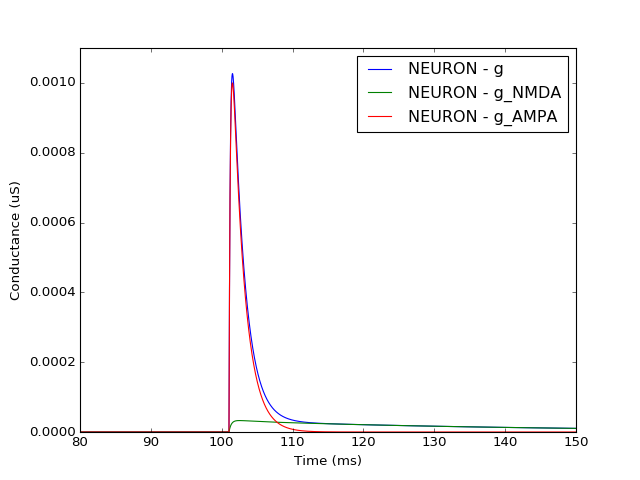

In [16]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON - g")
plot_timecourse(time, g_NMDA, ylabel="Conductance (uS)", label="NEURON - g_NMDA", newfigure=False)
plot_timecourse(time, g_AMPA, ylabel="Conductance (uS)", label="NEURON - g_AMPA", newfigure=False)
plt.axis([80.0, 150.0, 0.0, 0.0011])
plt.legend()

Finally, let's plot the dependence of the NMDA conductance on the Mg2+ concentration.

In [17]:
g_NMDA_1mM = numpy.zeros_like(g_NMDA)
g_NMDA_1mM[:] = g_NMDA

<IPython.core.display.Javascript object>


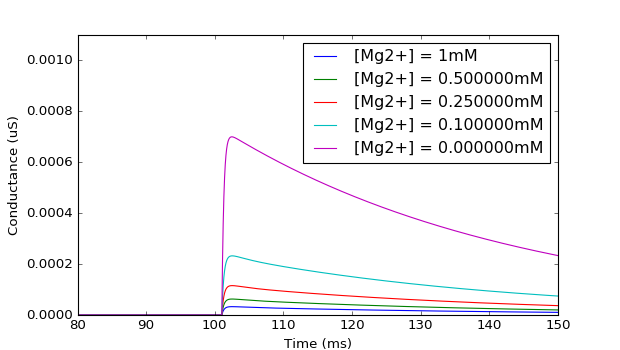

In [18]:
plot_timecourse(time, g_NMDA_1mM, ylabel="Conductance (uS)", label="[Mg2+] = 1mM")
mgs = [0.5, 0.25, 0.1, 0.0]
for mg in mgs:
    synapse.mg = mg
    neuron.h.run()
    plot_timecourse(time, g_NMDA, ylabel="Conductance (uS)", label="[Mg2+] = %fmM" % mg, newfigure=False)
plt.axis([80.0, 150.0, 0.0, 0.0011])
plt.legend()


The plot shows a marked increase in g_NMDA as [Mg2+] decreases, indicating the NMDA receptor requires the presence of Mg2+ for the voltage block to be effective.